In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "drive/MyDrive/COSC 606 Machine learning/Homework 2/Notebooks/"

'Task 1 OR gate with Softmax activation and Crossentropy loss.ipynb'
'Task 1 XOR gate with Sigmoid Activation and Squared Error Loss.ipynb'
'Task 1 XOR gate with Softmax activation and Crossentropy loss.ipynb'
'Task 2 work on MNIST data V1.ipynb'
'Task 3.1 Work on MNIST data V2.ipynb'
'Task 3.2 Work on MNIST data V3.ipynb'


In [ ]:
!pwd

/content


In [ ]:
import os
os.chdir('drive/MyDrive/COSC 606 Machine learning/Homework 2/Notebooks/')
!pwd

/content/drive/MyDrive/COSC 606 Machine learning/Homework 2/Notebooks


In [ ]:
import numpy as np  # import numpy library

In [ ]:
def initialize_parameters(n_in, n_out, ini_type='plain'):
    """
    Function to initialize some form of random weights and Zero biases
    Args:
        n_in: size of input layer
        n_out: size of output/number of neurons
        ini_type: set initialization type for weights
    Returns:
        params: a dictionary containing W and b
    """

    params = dict()  # initialize empty dictionary of neural net parameters W and b

    if ini_type == 'plain':
        params['W'] = np.random.randn(n_out, n_in) *0.01  # set weights 'W' to small random gaussian
    elif ini_type == 'xavier':
        params['W'] = np.random.randn(n_out, n_in) / (np.sqrt(n_in))  # set variance of W to 1/n
    elif ini_type == 'he':
        # Good when ReLU used in hidden layers
        params['W'] = np.random.randn(n_out, n_in) * np.sqrt(2/n_in)  # set variance of W to 2/n

    params['b'] = np.zeros((n_out, 1))    # set bias 'b' to zeros

    return params

In [ ]:
class LinearLayer:
    """
        This Class implements all functions to be executed by a linear layer
        in a computational graph
        Args:
            input_shape: input shape of Data/Activations
            n_out: number of neurons in layer
            ini_type: initialization type for weight parameters, default is "plain"
                      Opitons are: plain, xavier and he
        Methods:
            forward(A_prev)
            backward(upstream_grad)
            update_params(learning_rate)
    """

    def __init__(self, input_shape, n_out, ini_type="plain"):
        """
        The constructor of the LinearLayer takes the following parameters
        Args:
            input_shape: input shape of Data/Activations
            n_out: number of neurons in layer
            ini_type: initialization type for weight parameters, default is "plain"
        """

        self.m = input_shape[1]  # number of examples in training data
        # `params` store weights and bias in a python dictionary
        self.params = initialize_parameters(input_shape[0], n_out, ini_type)  # initialize weights and bias
        self.Z = np.zeros((self.params['W'].shape[0], input_shape[1]))  # create space for resultant Z output

    def forward(self, A_prev):
        """
        This function performs the forwards propagation using activations from previous layer
        Args:
            A_prev:  Activations/Input Data coming into the layer from previous layer
        """

        self.A_prev = A_prev  # store the Activations/Training Data coming in
        self.Z = np.dot(self.params['W'], self.A_prev) + self.params['b']  # compute the linear function

    def backward(self, upstream_grad):
        """
        This function performs the back propagation using upstream gradients
        Args:
            upstream_grad: gradient coming in from the upper layer to couple with local gradient
        """

        # derivative of Cost w.r.t W
        self.dW = np.dot(upstream_grad, self.A_prev.T)

        # derivative of Cost w.r.t b, sum across rows
        self.db = np.sum(upstream_grad, axis=1, keepdims=True)

        # derivative of Cost w.r.t A_prev
        self.dA_prev = np.dot(self.params['W'].T, upstream_grad)

    def update_params(self, learning_rate=0.1):
        """
        This function performs the gradient descent update
        Args:
            learning_rate: learning rate hyper-param for gradient descent, default 0.1
        """

        self.params['W'] = self.params['W'] - learning_rate * self.dW  # update weights
        self.params['b'] = self.params['b'] - learning_rate * self.db  # update bias(es)

In [ ]:
class SigmoidLayer:
    """
    This file implements activation layers
    inline with a computational graph model
    Args:
        shape: shape of input to the layer
    Methods:
        forward(Z)
        backward(upstream_grad)
    """

    def __init__(self, shape):
        """
        The consturctor of the sigmoid/logistic activation layer takes in the following arguments
        Args:
            shape: shape of input to the layer
        """
        self.A = np.zeros(shape)  # create space for the resultant activations

    def forward(self, Z):
        """
        This function performs the forwards propagation step through the activation function
        Args:
            Z: input from previous (linear) layer
        """
        self.A = 1 / (1 + np.exp(-Z))  # compute activations

    def backward(self, upstream_grad):
        """
        This function performs the  back propagation step through the activation function
        Local gradient => derivative of sigmoid => A*(1-A)
        Args:
            upstream_grad: gradient coming into this layer from the layer above
        """
        # couple upstream gradient with local gradient, the result will be sent back to the Linear layer
        self.dZ = upstream_grad * self.A*(1-self.A)

In [ ]:
def compute_cost(Y, Y_hat):
    """
    This function computes and returns the Cost and its derivative.
    The is function uses the Squared Error Cost function -> (1/2m)*sum(Y - Y_hat)^.2
    Args:
        Y: labels of data
        Y_hat: Predictions(activations) from a last layer, the output layer
    Returns:
        cost: The Squared Error Cost result
        dY_hat: gradient of Cost w.r.t the Y_hat
    """
    m = Y.shape[1]

    cost = (1 / (2 * m)) * np.sum(np.square(Y - Y_hat))
    cost = np.squeeze(cost)  # remove extraneous dimensions to give just a scalar

    dY_hat = -1 / m * (Y - Y_hat)  # derivative of the squared error cost function

    return cost, dY_hat

In [ ]:
# This is our XOR gate data 
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

Y = np.array([
    [0],
    [1],
    [1],
    [0]
])
print(X.shape)
print(Y.shape)

(4, 2)
(4, 1)


In [ ]:
# Setting up training data
X_train = X.T
Y_train = Y.T
print(X_train.shape)
print(Y_train.shape)


(2, 4)
(1, 4)


In [ ]:
# define training constants
learning_rate = 1
number_of_epochs = 5000

np.random.seed(48) # set seed value so that the results are reproduceable
                  # (weights will now be initailzaed to the same pseudo-random numbers, each time)


# Our network architecture has the shape: 
#                   (input)--> [Linear->Sigmoid] -> [Linear->Sigmoid] -->(output)  

#------ LAYER-1 ----- define hidden layer that takes in training data 
Z1 = LinearLayer(input_shape=X_train.shape, n_out=3, ini_type='xavier')
A1 = SigmoidLayer(Z1.Z.shape)

#------ LAYER-2 ----- define output layer that take is values from hidden layer
Z2= LinearLayer(input_shape=A1.A.shape, n_out=1, ini_type='xavier')
A2= SigmoidLayer(Z2.Z.shape)

In [ ]:
costs = [] # initially empty list, this will store all the costs after a certian number of epochs

# Start training
for epoch in range(number_of_epochs):
    
    # ------------------------- forward-prop -------------------------
    Z1.forward(X_train)
    A1.forward(Z1.Z)
    
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    
    # ---------------------- Compute Cost ----------------------------
    cost, dA2 = compute_cost(Y=Y_train, Y_hat=A2.A)
    
    # print and store Costs every 100 iterations.
    if (epoch % 100) == 0:
        print("Cost at epoch#{}: {}".format(epoch, cost))
        costs.append(cost)
    
    # ------------------------- back-prop ----------------------------
    A2.backward(dA2)
    Z2.backward(A2.dZ)
    
    A1.backward(Z2.dA_prev)
    Z1.backward(A1.dZ)
    
    # ----------------------- Update weights and bias ----------------
    Z2.update_params(learning_rate=learning_rate)
    Z1.update_params(learning_rate=learning_rate)

# See what the final weights and bias are training    
# print(Z1.params)
# print(Z2.params)

Cost at epoch#0: 0.12926510193084198
Cost at epoch#100: 0.12345825692804888
Cost at epoch#200: 0.12066966113381941
Cost at epoch#300: 0.11668036021258062
Cost at epoch#400: 0.11130833351272905
Cost at epoch#500: 0.10488049601356227
Cost at epoch#600: 0.09838889588798089
Cost at epoch#700: 0.09243739122926581
Cost at epoch#800: 0.08674109898244503
Cost at epoch#900: 0.08036338003614363
Cost at epoch#1000: 0.07188849409230211
Cost at epoch#1100: 0.06026682287648238
Cost at epoch#1200: 0.04667277906214774
Cost at epoch#1300: 0.034031803169728744
Cost at epoch#1400: 0.02442089220979804
Cost at epoch#1500: 0.017883350379483135
Cost at epoch#1600: 0.013556791347344183
Cost at epoch#1700: 0.010645079603116687
Cost at epoch#1800: 0.00862108131339213
Cost at epoch#1900: 0.007164447639006826
Cost at epoch#2000: 0.006081828121979098
Cost at epoch#2100: 0.005254042338109353
Cost at epoch#2200: 0.004605397868807181
Cost at epoch#2300: 0.0040862927529649404
Cost at epoch#2400: 0.003663237628268156
C

In [ ]:
def predict(X, Y, Zs, As):
    m = X.shape[1]
    n = len(Zs)  # number of layers in the neural network
    p = np.zeros((1, m))

    # Forward propagation
    Zs[0].forward(X)
    As[0].forward(Zs[0].Z)
    for i in range(1, n):
        Zs[i].forward(As[i-1].A)
        As[i].forward(Zs[i].Z)
    probas = As[n-1].A

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:  # 0.5 is threshold
            p[0, i] = 1
        else:
            p[0, i] = 0

    accuracy = np.sum((p == Y) / m)

    return p, probas, accuracy*100

In [ ]:
predicted_outputs, _, accuracy = predict(X=X_train, Y=Y_train, Zs=[Z1, Z2], As=[A1, A2])

print("The predicted outputs:\n {}".format(predicted_outputs))
print("The accuracy of the model is: {}%".format(accuracy))

The predicted outputs:
 [[0. 1. 1. 0.]]
The accuracy of the model is: 100.0%


In [ ]:
def plot_learning_curve(costs, learning_rate, total_epochs, save=False):
    """
    This function plots the Learning Curve of the model

    Args:
        costs: list of costs recorded during training
        learning_rate: the learning rate during training
        total_epochs: number of epochs the model was trained for
        save: bool flag to save the image or not. Default False
    """
    # plot the cost
    import matplotlib.pyplot as plt
    plt.figure()

    steps = int(total_epochs / len(costs))  # the steps at with costs were recorded
    plt.ylabel('Cost')
    plt.xlabel('Iterations ')
    plt.title("Learning rate =" + str(learning_rate))
    plt.plot(np.squeeze(costs))
    locs, labels = plt.xticks()
    plt.xticks(locs[1:-1], tuple(np.array(locs[1:-1], dtype='int')*steps))  # change x labels of the plot
    plt.xticks()
    if save:
        plt.savefig('Cost_Curve.png', bbox_inches='tight')
    plt.show()

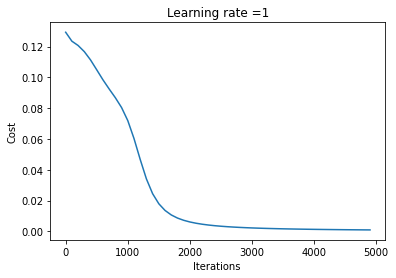

In [ ]:
plot_learning_curve(costs=costs, learning_rate=learning_rate, total_epochs=number_of_epochs)